# Fitness assay simulations

In this project, I explore the limitations of inferring fitness effects and gene essentiality from bulk fitness assays such as deep mutational scans, CRISPR screens, transposon sequencing approaches ([TnSeq](https://www.nature.com/articles/nmeth.1377), [TraDIS](https://genome.cshlp.org/content/19/12/2308.short), [InSeq](https://www.sciencedirect.com/science/article/pii/S1931312809002819), [HITS](https://www.pnas.org/doi/abs/10.1073/pnas.0906627106)). In these papers, transposons are used to disrupt genes (somewhat randomly), and tracking frequencies of a pool (or library) of these mutants using sequencing as a readout.  Because these approaches involve competing thousands of mutants together, a mutant with a mild fitness defect may appear similar to a mutant in a gene essential for growth (say a gene like RNA Polymerase). 

Here, I simulate fitness assays (grounded in experimental data), and propose an approach for defining a threshold beyond which it is not possible to distinguish deleterious mutations from mutations in essential genes.

### Definitions/Terminology

- Essential gene: here I work with a very strict defition of essentiality. A gene is essential if a cell cannot grow without it. As an example, a 50% reduction in growth rate is not considered essentiality under this strict defition. 
- Neutral gene: a gene which when lost has no impact on cellular growth.
- Deleterious genes: genes which when lost lead to a reduction in growth rate. Note that deleterious genes lie in a continuum between essential genes and neutral genes.
- Fitness: the per-generation log-fold change in frequency of a mutant.

In [1]:
#importing libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from Bio.SeqIO.FastaIO import SimpleFastaParser
import re
import pandas as pd
import seaborn as sns
import pathlib
import os

In [471]:
sns.set_theme()
sns.set_context('paper')

### Loading metadata

In [3]:
#current working directory
cwd = os.getcwd()
print(cwd)

/Users/anuraglimdi/github/2022_Limdi_limits-pooled-fitness-assays/AnalysisNotebooks


In [4]:
#use the pathlib.Path function to get the parent directories-> goal is to navigate to directory with the metadata
# and the fitness trajectories data
path = pathlib.Path(cwd)
repo = str(path.parents[0])
print(path.parents[0]) #this should be the base directory for the github repository: the exact path will differ for 
#each unique user

/Users/anuraglimdi/github/2022_Limdi_limits-pooled-fitness-assays


In [5]:
#paths for metadat and mutant trajectories
metadata_path = repo+'/Metadata/'
data_path = repo+'/ProcessedData/Mutant_Trajectories/'

In [6]:
#names of libraries
libraries = ['REL606']
#more interpretable names for the figures in the paper
libraries2 = ['Anc']

In [7]:
#opening the pandas file with all the metadata!
all_data = pd.read_csv(metadata_path+"all_metadata_REL606.txt", sep="\t")
names = all_data.iloc[:,0]
gene_start = all_data.iloc[:,3]
gene_end = all_data.iloc[:,4]
strand = all_data.iloc[:,5]
locations = np.transpose(np.vstack([gene_start,gene_end,strand]))
k12_tags = all_data.iloc[:,2]
uniprot_rel606 = all_data.iloc[:,6]

#genomic coordinates of pseudogenes
locations_pseudogenes = np.loadtxt(metadata_path+'pseudogenes_locations_REL606.txt')

In [8]:
#fractions of the gene at the 5' and 3' ends to be excluded from analysis because they insertions there may not actually
#be disruptive to protein function
frac5p = 0.1
frac3p = 0.25

#reading the REL606 reference genome
with open(metadata_path+"rel606_reference.fasta") as in_handle:
    for title, seq in SimpleFastaParser(in_handle):
        ta_sites = [m.start(0) for m in re.finditer('TA', seq)]
ta_sites = np.array(ta_sites)

#counting how many TA sites are present in the interior of each gene
ta_gene = np.zeros(len(names))
for i in range(0,len(names)):
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        #counting sites only in the middle of the gene, excluding defined fractions at each end
        ta_gene[i] = np.sum((ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p))
    elif locations[i,2]==-1:
        ta_gene[i] = np.sum((ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p))

### Loading the mutant trajectories data for the LTEE Ancestor

In [9]:
#all the information from the fitness assay condensed into a couple of matrices
counts_all_green = np.zeros([5, len(ta_sites)])
counts_all_red = np.zeros([5, len(ta_sites)])

#loading the new file where I have the counts for each TA site for all time points
gname = data_path+'/green_'+libraries[0]+'_merged_all_TAsites.txt'
greendata = np.loadtxt(gname)
rname = data_path+'/red_'+libraries[0]+'_merged_all_TAsites.txt'
reddata = np.loadtxt(rname)
#now for extracting the UMI corrected counts
counts_all_green = greendata[2:11:2,:]
counts_all_red = reddata[2:11:2,:]

The data is organized as follows:
- each column corresponds to a TA transposon insertion site in the genome
- each row corresponds to a timepoint in the fitness assay (we have a total of 5 timepoints)
- green and red refer to experimental replicates of the fitness assay (they were named as such because I used red and green sharpies to label tubes in the lab)
- the $t_{0}$ timepoint is the same for the two replicates: I took the transposon library from the freezer, extracted DNA from it, and split it into two replicate fitness assays

In [10]:
#number of sequencing reads in the "red" replicate
print('red\t', counts_all_red.sum(axis=1))
#number of sequencing reads in the "red" replicate
print('green\t', counts_all_green.sum(axis=1))

red	 [15071951. 10926749. 15528916. 18645080. 16380071.]
green	 [15071951. 16444999. 12387024. 14560311. 14105362.]


## Mutant trajectories at different sequencing depths

Approach:

- Downsample the fitness assay counts by the same factor across timepoints
- Compare mutant trajectories for the same genes (spanning a range of fitnesses) at different sequencing depths
- Compare the estimated fitness from downsampled data to the "true" fitness (from the highest sequencing depth), and observe how this changes with sequencing depth.

Questions we're exploring:

- Do mutant trajectories for deleterious and essential genes start becoming more similar as sequencing depth decreases? This would start to hint at a key point of the paper: our ability to distinguish deleterious fitness effects gets worse with less sequencing depth
- Is there a point beyond which increasing sequencing depth does not lead to a meaningful improvement in convergence to "true" fitness (while acknowledging that we don't have a ground truth)?

#### Defining some important functions


In [11]:
def downsample(data, scale):
    """
    Inputs: 
    - data: counts matrix for bulk fitness assay
    - scale: scaling factor for downsampling, must be greater than 1.
    
    Process:
    - downsample number of reads mapping to an insertion site as follows (for each time point, here: by row)
    - use np.repeat to get an list with every insertion site repeated N times, where N is the number of mapped reads
    - use np.shuffle to rearrange this list
    - pick the first 1/scale fraction of this list
    - use np.unique to which sites are represented, and how frequently after downsampling.
    
    Output:
    - data_scaled: same shape as data but each row of the matrix downsampled by the scaling factor
    """
    assert scale >= 1, f"downsampling scale factor must be greater than/equal 1"
    
    if scale == 1: #do not downsample the data at all:
        return data
    
    else:
        data_scaled = np.zeros_like(data)

        for t in range(data.shape[0]): #there are 5 timepoints in the data
            #this is the key step in the process, every TA site is repeated as many times as number of reads mapping to it
            explicit_data = np.repeat(np.arange(0,data.shape[1]), data[t,:].astype('int'))
            #this list is then shuffled
            np.random.shuffle(explicit_data)
            #and a subset of this list becomes the new data
            N_ds = int(data.sum(axis=1)[t]/scale)
            #as we shuffled the data, taking the first N_ds reads is equivalent to taking a 1/scale random subset of the data
            downsampled = explicit_data[:N_ds]
            #getting the counts and unique TA sites represented after downsampling
            unique, counts = np.unique(downsampled, return_counts=True)
            data_scaled[t,unique] = counts
        
        return data_scaled

In [12]:
def search_gene(locations,ta_sites,i):
    """
    Input: 
    locations: gene coordinates, start, end and orientation
    ta_sites: list of TA sites
    i: query gene
    
    Returns:
    mask corresponding to the interior of the 'i'th gene in the E. coli genome
    """
    start = locations[i, 0]
    end = locations[i, 1]
    length = end - start
    #if the gene is on the forward strand
    if locations[i,2]==1:
        search_area = (ta_sites > start+length*frac5p)&(ta_sites < end - length*frac3p)
    #if the gene is on the reverse strand
    elif locations[i,2]==-1:
        search_area = (ta_sites < start+length*frac5p)&(ta_sites > end - length*frac3p)
    return search_area

In [50]:
def simulate_assay(initial_counts, s_mut, t, gens):
    """
    Input:
    initial_counts: read counts before fitness assay
    s_mut: fitness effect of disrupting gene (or more generally of the mutation)
    t: number of timepoints for assay
    gens: number of generations per timepoint
    
    Output:
    simulates a fitness trajectory assuming that expected number of counts at any given time point is Poisson
    distributed with mean specified by mutant fitness
    """
    sim_traj = np.zeros([initial_counts.shape[0], t])
    #initialize:
    sim_traj[:,0] = initial_counts
    #running the simulation
    for t in range(1, t):
        expected_counts = sim_traj[:,t-1]*np.exp(s_mut*gens)
        #actual counts are drawn from a Poisson distribution
        sim_traj[:, t] = np.random.poisson(expected_counts)
    
    return sim_traj

In [669]:
def fitness_calculator(trajectories, n_gens):
    sites = trajectories.shape[0]
    time = trajectories.shape[1]
    time_range = np.linspace(0, time-1, time)*n_gens
    
    s_site = [np.polyfit(time_range, np.log(trajectories[i, :]), 1)[0] for i in range(sites) if np.min(trajectories[i,:]>0)]
    return np.mean(s_site), np.std(s_site)

In [848]:
def fitness_calculator_replicates(trajectories, n_gens, reps, uncalculated_count=None):
    """
    trajectories: simulated data
    n_gens: number of generations of selection per day
    reps: number of replicates to average over for estimating fitness
    """
    time = trajectories.shape[1]
    time_range = np.linspace(0, time-1, time)*n_gens
    mutations = int(trajectories.shape[0]/reps)
    s_mutation = np.zeros(mutations)-1
    err_mutation = np.zeros(mutations)-1
    for i in range(mutations):
        splice = trajectories[i:i+reps, :]
        s_rep = [np.polyfit(time_range, np.log(splice[k, :]), 1)[0] for k in range(reps) if np.min(splice[k,:]>0)]
        if np.size(s_rep)>1:
            err_mutation[i] = np.std(s_rep)/np.sqrt(len(s_rep)-1)
            s_mutation[i] = np.mean(s_rep)
    
    num_uncalculated=np.sum(s_mutation==-1)
    
    if uncalculated_count==None:
        return np.mean(s_mutation[s_mutation>-1]), np.mean(err_mutation[err_mutation>-1])
    else:
        return np.mean(s_mutation[s_mutation>-1]), np.mean(err_mutation[err_mutation>-1]), num_uncalculated

In [851]:
trajs = simulate_assay(initial_counts=np.ones(1000)*100, s_mut=-0.1, t=5, gens=np.log2(100))
fitness_calculator_replicates(trajs, n_gens=np.log2(100), reps=5, uncalculated_count=True)

(-0.10241454539210276, 0.008312974591796652, 0)

### Exploring errors in simulated data for near-neutral fitness effects

defined as $s\in [-0.1, 0.05]$

Approach:

- for every fitness effect, simulate trajectories for 10 replicates, changing sequencing depth, number of generations per day and number of days
- for every simulation, calculate fitnesses and estimate the standard error of the measurement


In [551]:
n_generations = np.linspace(5,20,4)
n_days = np.linspace(2,5,4)
seq_depth = np.array([20,50,100])

In [767]:
trajs = simulate_assay(initial_counts=np.ones(1000)*100, s_mut=0, t=2, gens=10)

In [768]:
fitness_calculator_replicates(trajs, 10, 5)

(-0.0018313769330815237, 0.0031252697091362688)

### Fig 1: Uncertainty in error as a function of true fitness

In [724]:
error = []
for s in np.linspace(-0.25, 0.1, 100):
    trajs = simulate_assay(initial_counts=np.ones(4000)*100, s_mut=s, t=2, gens=np.log2(100))
    mean, std = fitness_calculator_replicates(trajs, np.log2(100), 5)
    error.append(std)

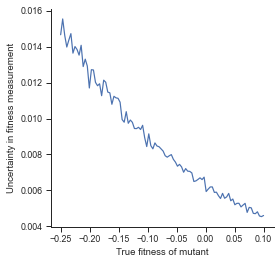

In [725]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    plt.plot(np.linspace(-0.25, 0.1, 100), error)
    plt.xlabel('True fitness of mutant')
    plt.ylabel('Uncertainty in fitness measurement')
    sns.despine()
    plt.show()

### Fig 2: how does error in fitness estimates depend on experimental parameters such as sequencing depth, number of bottlenecks, and number of generations per day?

Sequencing depth

In [735]:
error = []
for depth in np.linspace(10,200,50):
    trajs = simulate_assay(initial_counts=np.ones(1000)*depth, s_mut=0, t=2, gens=np.log2(100))
    mean, std = fitness_calculator_replicates(trajs, np.log2(100), 5)
    error.append(std)

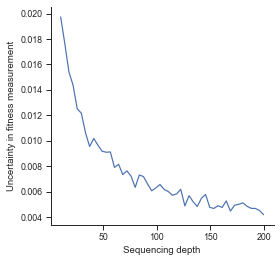

In [736]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    plt.plot(np.linspace(10,200,50), error)
    plt.xlabel('Sequencing depth')
    plt.ylabel('Uncertainty in fitness measurement')
    sns.despine()
    plt.show()

Number of bottlenecks

In [856]:
error = []
for time in np.linspace(2,6,5):
    trajs = simulate_assay(initial_counts=np.ones(1000)*100, s_mut=0, t=time.astype('int'), gens=np.log2(100))
    mean, std = fitness_calculator_replicates(trajs, np.log2(100), 5)
    error.append(std)

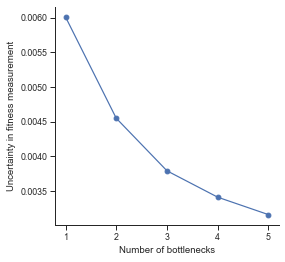

In [861]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    plt.plot(np.linspace(2,6,5)-1, error, '-o')
    plt.xlabel('Number of bottlenecks')
    plt.ylabel('Uncertainty in fitness measurement')
    plt.xticks(np.linspace(2,6,5)-1)
    sns.despine()
    plt.show()

Two dimensional plots of number of days vs sequencing. This one is important because it may be useful to know if it's better to have more days or more depth per day for fixed number of reads

In [975]:
depth_days = np.zeros([50,5])
seq_depth = np.linspace(10,200,50)
days_range = np.linspace(2,6,5).astype('int')

In [976]:
for i in range(len(seq_depth)):
    for j in range(len(days_range)):
        trajs = simulate_assay(initial_counts=np.ones(10000)*seq_depth[i], s_mut=0, t=days_range[j], gens=np.log2(100))
        mean, std = fitness_calculator_replicates(trajs, n_gens=np.log2(100), reps=5)
        depth_days[i,j] = std

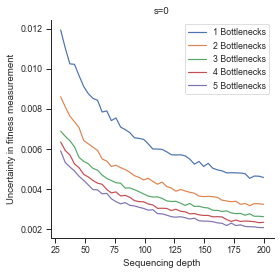

In [977]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    for i in range(len(days_range)):
        plt.plot(seq_depth[5:], depth_days[5:, i], label=f'{days_range[i]-1} Bottlenecks')
        plt.xlabel('Sequencing depth')
        plt.ylabel('Uncertainty in fitness measurement')
    plt.legend(loc=0)
    sns.despine()
    plt.title(f's={0}')
    plt.show()

Repeating the above simulation but including an additional 1/N factor for sampling noise during a bottleneck?

In [993]:
depth_days_bot = np.zeros([50,5])
bottleneck = 200
for i in range(len(seq_depth)):
    for j in range(len(days_range)):
        sample_depth = 1/(1/bottleneck+1/seq_depth[i])
        trajs = simulate_assay(initial_counts=np.ones(10000)*sample_depth, s_mut=0, t=days_range[j], gens=np.log2(100))
        mean, std = fitness_calculator_replicates(trajs, n_gens=np.log2(100), reps=5)
        depth_days_bot[i,j] = std


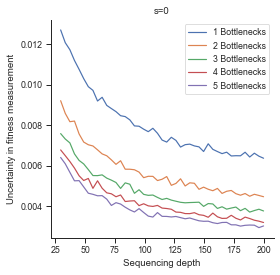

In [994]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    for i in range(len(days_range)):
        plt.plot(seq_depth[5:], depth_days_bot[5:, i], label=f'{days_range[i]-1} Bottlenecks')
        plt.xlabel('Sequencing depth')
        plt.ylabel('Uncertainty in fitness measurement')
    plt.legend(loc=0)
    sns.despine()
    plt.title(f's={0}')
    plt.show()

### Fig 2x?? Bottleneck size

- relevant quantity is not the number of generations in the assay but how many cells/mutant at each bottleneck
- for this calculation, assume that there is no noise in the PCR amplification and sequencing steps

### Fig 3: how does error in estimates for deleterious mutations depend on experimental parameters?

error vs sequencing depth for range of deleterious fitness effects 

In [990]:
depth_fitness = np.zeros([50,6])
s_range = np.linspace(-0.25,0,6)

In [991]:
for i in range(len(seq_depth)):
    for j in range(len(s_range)):
#         sample_depth=1/(1/bottleneck+1/seq_depth[i])
        trajs = simulate_assay(initial_counts=np.ones(5000)*seq_depth[i], s_mut=s_range[j], t=2, gens=np.log2(100))
        mean, std = fitness_calculator_replicates(trajs, n_gens=np.log2(100), reps=5)
        depth_fitness[i,j] = std

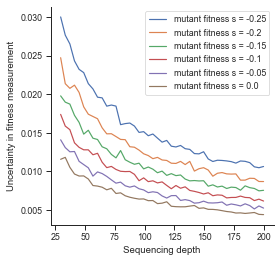

In [992]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    for i in range(len(s_range)):
        plt.plot(np.linspace(10,200,50)[5:], depth_fitness[5:, i], label=f'mutant fitness s = {np.round(s_range[i],2)}')
        plt.xlabel('Sequencing depth')
        plt.ylabel('Uncertainty in fitness measurement')
    plt.legend(loc=0)
    sns.despine()
    plt.show()

coverage/bottlenecks plot for a slightly deleterious mutations

In [1015]:
uncalc_data = np.zeros([len(seq_depth), len(days_range)-1])
mean_data = np.zeros([len(seq_depth), len(days_range)-1])
for i in range(len(seq_depth)):
    for j in range(len(days_range)-1):
        trajs = simulate_assay(initial_counts=np.ones(5000)*seq_depth[i], s_mut=-0.4, t=days_range[j], gens=np.log2(100))
        mean, std, uncalc = fitness_calculator_replicates(trajs, np.log2(100), reps=5, uncalculated_count=True)
        depth_days[i,j] = std
        uncalc_data[i,j] = uncalc
        mean_data[i,j] = mean
#         print(uncalc, seq_depth[i], mean)

/Users/anuraglimdi/opt/miniconda3/envs/ml_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anuraglimdi/opt/miniconda3/envs/ml_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


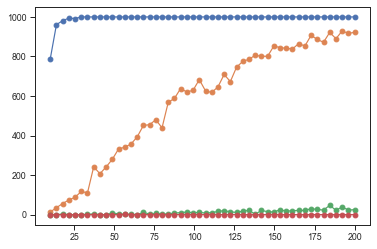

In [1016]:
with sns.axes_style('ticks'):
    for i in range(len(days_range)-1):
        plt.plot(np.linspace(10,200,50), 1000-uncalc_data[:,i], 'o-')
plt.show()
    #     plt.yscale('log')

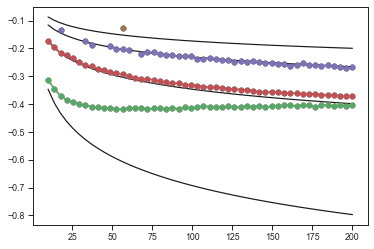

In [1017]:
with sns.axes_style('ticks'):
    for i in range(len(days_range)-1):
        plt.plot(np.linspace(10,200,50), mean_data, 'o-')
        plt.plot(np.linspace(10,200,50), np.log(1/np.linspace(10,200,50))/(days_range[i]-1)/np.log2(100), 'k')
    #     plt.yscale('log')
#     plt.ylim(-0.35)
    plt.show()

In [917]:
days_range

array([2, 3, 4, 5, 6])

### Figure 4: Resolving deleterious mutations

For a set of parameters, what is the probability of observing zero counts at the next timepoint?

In [885]:
n_generations = np.array([6,8,10,12,15,20])
s_range = np.linspace(-np.log(2), -0.1, 100)
coverage = np.array([10,20,50,100,200])

In [875]:
def dropout_probability(fitness, generations, depth):
    expected_counts = depth*np.exp(fitness*generations)
    return np.exp(-expected_counts) #p(0) = e^(-lambda)

In [876]:
prob_gens = [dropout_probability(s_range, gens, depth=25) for gens in n_generations]

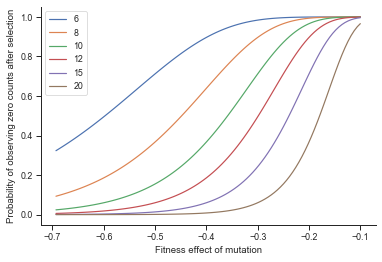

In [931]:
with sns.axes_style('ticks'):
    plt.plot(s_range, 1-np.transpose(prob_gens), label = n_generations)
    plt.legend()
    plt.xlabel('Fitness effect of mutation')
    plt.ylabel('Probability of observing zero counts after selection')
    sns.despine()

In [887]:
prob_coverage = [dropout_probability(s_range, generations=10, depth=depth) for depth in coverage]

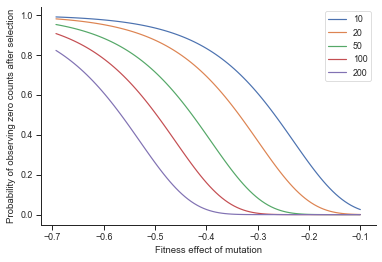

In [888]:
with sns.axes_style('ticks'):
    plt.plot(s_range, np.transpose(prob_coverage), label = coverage)
    plt.legend()
    plt.xlabel('Fitness effect of mutation')
    plt.ylabel('Probability of observing zero counts after selection')
    sns.despine()

This suggests that for deleterious mutations, decreasing the number of generations and increasing coverage can increase the amount of available data for estimating fitness from. I think this should be supplementary.

The more relevant figure is the following:

In [960]:
prob_survival = np.zeros([len(seq_depth), len(days_range)-1])
prob_survival.shape

(50, 4)

In [961]:
for i in range(len(days_range)-1):
    for d in range(len(seq_depth)):
        prob_survival[d, i] = dropout_probability(fitness=-0.25, generations=np.log2(100)*(days_range[i]-1), depth=seq_depth[d])

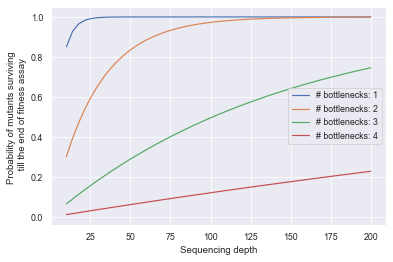

In [968]:
for i in range(len(days_range)-1):
    plt.plot(seq_depth, 1-prob_survival[:,i], label='# bottlenecks: '+str(days_range[i]-1))
    plt.xlabel('Sequencing depth')
    plt.ylabel('Probability of mutants surviving \n till the end of fitness assay')
    plt.legend()

### Figure 5: More replicates or more depth per replicate?

For a fixed sequencing depth, there is a tradeoff between measuring many mutants with lower precision, and fewer mutations with very high precision. Here, I'll do some quick estimates on how the error varies with number of replicates, while also changing the total reads and fitness of the mutation.

In [1009]:
total_reads = 10**2
replicate_range = np.linspace(2,25,24)

In [1010]:
error = []
#first a neutral mutation
for rep in replicate_range:
    coverage1 = total_reads/rep
    error.append(1/6.64/np.sqrt(rep)*np.log((coverage1+np.sqrt(coverage1))/(coverage1-np.sqrt(coverage1))))

In [1011]:
error1 = []
error2 = []
s = -0.3
#now a deleterious mutation
for rep in replicate_range:
    coverage1 = total_reads/rep
    coverage2 = coverage1*np.exp(s*6.64)
    upper_bound = 1/6.64*np.log((coverage2+np.sqrt(coverage2))/(coverage1-np.sqrt(coverage1)))
    lower_bound = 1/6.64*np.log((coverage2-np.sqrt(coverage2))/(coverage1+np.sqrt(coverage1)))
    error1.append(1/np.sqrt(rep-1)*(upper_bound-s))
    error2.append(1/np.sqrt(rep-1)*(lower_bound-s))
#     print(upper_bound, lower_bound, rep)


<ipython-input-1011-b04fc257ede6>:9: RuntimeWarning: invalid value encountered in log
  lower_bound = 1/6.64*np.log((coverage2-np.sqrt(coverage2))/(coverage1+np.sqrt(coverage1)))


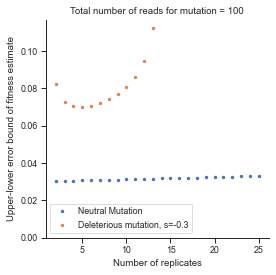

In [1012]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    plt.plot(replicate_range, error, '.', label='Neutral Mutation')
    plt.plot(replicate_range, (np.abs(error2)+np.array(error1))/2, '.', label=f'Deleterious mutation, s={s}')
    plt.legend(loc=0)
    plt.xlabel('Number of replicates')
    plt.ylabel('Upper-lower error bound of fitness estimate')
    plt.title(f'Total number of reads for mutation = {total_reads}')
    plt.ylim(0)
    sns.despine()